## Importing libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from summarytools import dfSummary
from scipy import stats
from scipy.stats import normaltest
import scipy.stats as stats
from sklearn.model_selection import train_test_split
from scipy.stats import spearmanr
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
print(pd.__version__)
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
import joblib

1.5.3


In [2]:
print(sns.__version__)

0.12.1


In [3]:
#pip install pandas==1.5.3

## Reading the data and overall Summary

In [4]:
churn_data = pd.read_csv("customer_churn_dataset-testing-master.csv")
churn_data

,CustomerID,Age,Gender,Tenure,Usage Frequency,Support Calls,Payment Delay,Subscription Type,Contract Length,Total Spend,Last Interaction,Churn
0,1,22,Female,25,14,4,27,Basic,Monthly,598,9,1
1,2,41,Female,28,28,7,13,Standard,Monthly,584,20,0
2,3,47,Male,27,10,2,29,Premium,Annual,757,21,0
3,4,35,Male,9,12,5,17,Premium,Quarterly,232,18,0
4,5,53,Female,58,24,9,2,Standard,Annual,533,18,0
...,...,...,...,...,...,...,...,...,...,...,...,...
64369,64370,45,Female,33,12,6,21,Basic,Quarterly,947,14,1
64370,64371,37,Male,6,1,5,22,Standard,Annual,923,9,1
64371,64372,25,Male,39,14,8,30,Premium,Monthly,327,20,1
64372,64373,50,Female,18,19,7,22,Standard,Monthly,540,13,1


# EDA

In [5]:
dfSummary(churn_data, is_collapsible=False)

No,Variable,Stats / Values,Freqs / (% of Valid),Graph,Missing
1,CustomerID[int64],Mean (sd) : 32187.5 (18583.3)min < med < max:1.0 < 32187.5 < 64374.0IQR (CV) : 32186.5 (1.7),"64,374 distinct values","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAKoAAABGCAYAAABc8A97AAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjcuMiwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8pXeV/AAAACXBIWXMAAA9hAAAPYQGoP6dpAAABxklEQVR4nO3XQU7CYBBA4fkbJSCkDSHCAbwBSw7hYT0EJ2DhxhU7EtKUUDEarCcAKTXqS963baczixcSUtM0If132V8fIF3i5rsXUkqDiOhd+f0sIj6vnO06T91Nvbvr/HvTNIdTD8+GmlIaTCaTxzzPx223Ho/H27quH0aj0UuWZR+/OU/dTb37J+Z3u12ZUno6Fet3v6i9PM/Hi8XiUBTFW5vF6/V6vFqt7ufz+fNsNivbzHadp+6m3t11vqqq/nK5HG+3215EXBVqREQURfE2nU5f2ywvy3IQETEcDlvPdp2n7qbe/RPzETE499A/U0IwVCEYqhAMVQiGKgRDFYKhCsFQhWCoQjBUIRiqEAxVCIYqBEMVgqEKwVCFYKhCMFQhGKoQDFUIhioEQxWCoQrBUIVgqEIwVCEYqhAMVQiGKgRDFYKhCsFQhWCoQjBUIRiqEAxVCIYqBEMVgqEKwVCFYKhCMFQhGKoQDFUIhioEQxWCoQrBUIVgqEIwVCEYqhAMVQiGKgRDFYKhCsFQhWCoQjBUIRiqEAxVCIYqBEMVgqEK4eaSl6qq6rf98H6/70dE1HXd32w2d785T91Nvbvr/CV9fQGSljnmc7n3zQAAAABJRU5ErkJggg=="">",0(0.0%)
2,Age[int64],Mean (sd) : 42.0 (13.9)min < med < max:18.0 < 42.0 < 65.0IQR (CV) : 24.0 (3.0),48 distinct values,"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAKoAAABGCAYAAABc8A97AAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjcuMiwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8pXeV/AAAACXBIWXMAAA9hAAAPYQGoP6dpAAACj0lEQVR4nO3du47aQBiG4X9gAXOQEUKBjiZlpBSUXEQuNpewBVdAsU0qOiSEQDiLMIY02SJSlsOMwXzW+7SrfxlL7yB71tK60+lkwLOrFL0A4BovRS8A+XLONc2s7jm+P51O73muJy+EWiLOuWa/3/8Rx3HPZ36z2ayccz99Y73nJiHUcqnHcdybTCbv3W53d8vger2OptNpb7lc1s3s5lDvvUkItYS63e5uMBj8vnUuy7LYzGLnnM/Hxp1OZzCZTDb32CSECjMzS5Kklqbp99FoVK1WqzeFZmaWpmmUZdm3RqPx6rNJzKx57oeECjMz2+/3L1EUtcbj8W44HK5unZ/P573ZbNY6HA7Ve6yPUPGPdrvtdduwWq3OfiOGuhhq4JNcxcyOnrOh80FHLQVe99MeERXpbKghT3JZltWSJPna6XR+VSqV9NHzIUctRV536BFRWV36RvU+7vh7z/JlPB6/BdzzeM2HHrVYQdedw7pL66p7VJ/jjo97ltB7Ht95u/AUeY0irttyWHcZ8bd+SCBUSCBUSCBUSCBUSCBUSCBUSCjt3/qzLKtZwCtrx+OxlvOSEKCUoeb1ytput3s1M59De29ssP8rZajP/sraZ5Q32L2VMtQPz/rK2mdUN9gjlDpUVWob7BF46ocEQoUEQoUEQoUEQoUEQoUEQoUEQoUEQoUEQoUEQoUEQoUEQoUEQoUEQoUEQoUEQoUEQoUEQoUEQoUEQoUEQoUEQoUEQoUEQoUEQoUEQoUEQoUEQoUEQoUEQoUEQoUEQoUEQoUEQoUEQoUEQoUEQoUEQoUEQoUEQoUEQoUEQoUEQoWEq/5p73q9jm79xdvtNjIzS5IkWiwWrUfOq3626rpD56/p6w90koXYUHYVcQAAAABJRU5ErkJggg=="">",0(0.0%)
3,Gender[object],1. Female2. Male,"34,353 (53.4%)30,021 (46.6%)","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAAAuCAYAAAA/ZmtKAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjcuMiwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8pXeV/AAAACXBIWXMAAA9hAAAPYQGoP6dpAAABO0lEQVR4nO3bQWrDMBRF0a8iQjORMAYvxovoYrsI7cYYa9CETNRBp8EaVDw5zj0r+JiLIcHPlVIMUHBmdjWzS+9DTuJRSrn1PuKo/DiOXyGEofchZ5BzXp1z3wT3nA8hDPM832KM997HvLJt2z5TSsOyLBczI7YnvJlZjPE+TdNP72NO4Nr7gCP76H0A3gexQYbYIENskCE2yBAbZIgNMsQGGWKDDLFBhtggQ2yQITbIEBtkiA0y3uzvw7/eh7w6nmGdzzmvKaXB+PDv33LOq5k9et9xVAxe2mLwssMx5YMKb7Y63laNMOWrYJ7XDlO+Hczz2mLKV8ev9Eb4UxcyxAYZYoMMsUGG2CBDbJAhNsgQG2SIDTLEBhligwyxQYbYIENskCE2yDDl28FzaYspXwXzvHYYvNQxeGnkFwpbat8v4z0mAAAAAElFTkSuQmCC"">",0(0.0%)
4,Tenure[int64],Mean (sd) : 32.0 (17.1)min < med < max:1.0 < 33.0 < 60.0IQR (CV) : 29.0 (1.9),60 distinct values,"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAKoAAABGCAYAAABc8A97AAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjcuMiwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8pXeV/AAAACXBIWXMAAA9hAAAPYQGoP6dpAAACuUlEQVR4nO3asU8aYRjH8ecFMa9i74JQ3Fg6mnQgcXHp1rF/bNduNcGks0OXTi7GhCCEq4STo0NjbBpF7n1P8Ue+n9nHO3m/Eb0Ht1wuDXjrapu+AWAdO5u+AVTLObdnZruB4/Plcnlb5f1UhVCfsKkDj7yuPzw8/JymaTNk+ObmZuqc+2Zms8Dr18ysCJxd+ZoR6iOcc3vtdvtLkiStkPmIA48KLc9zb2bHJycnPzqdzqTM7NXV1bvz8/NPvV6vU6/XS4e6WCwaWZZ9ODg4+FWr1fKy85PJZOSc+/pUrIT6uN0kSVqnp6e3aZqWOrSYA48Jzczs8vKydXFxse+9z7vd7u8ys6PRaM97v9/v92dHR0ejwGu/7/f7P8vOj8djPxgMWsPhcNfMCLWsNE1nr3ngMaHdX7vszP+azWbpn/nfa4fOm9nKeyfUFxJyYFWEtq14PAUJhAoJhAoJhAoJhAoJhAoJW/t4KnIVmRRF0ajyfhDn2VAjDzxm92sWuDOPXYHmee4Xi8XxbDb7bmYhD69RsZWhxhx47O7X7Pn97wrBK1Czhw3R3d1dvewsXsZzv1GDDzxm92v2d/97dnbWHQ6HHedc2b13UhRFI03T0aZWkajWWn+jhu68zcJ3v1mWNfI8/9jr9eohH+7grXu7vNl/

In [6]:
churn_data.isnull().sum()

CustomerID           0
Age                  0
Gender               0
Tenure               0
Usage Frequency      0
Support Calls        0
Payment Delay        0
Subscription Type    0
Contract Length      0
Total Spend          0
Last Interaction     0
Churn                0
dtype: int64

From the summary ;

i. We can see there are no missing values and duplicates

ii.That there 64,374 customers in the dataset, out of that 34,353 (53.4%) are females and 30,021 (46.6%) are males , meaning the females are more that the males 

iii. There are three subcription types; Standard, basic , premium

iv. There are also three contract lenghth; Monthly , Annual , Quaterly


### The percentage of churned vs. non-churned customers?

In [7]:
print(churn_data["Churn"].value_counts())

# Calculate churn percentages
churn_counts = churn_data["Churn"].value_counts(normalize=True) * 100

# Display the percentages
print(f"Percentage of Non-Churned Customers: {churn_counts[0]:.2f}%")
print(f"Percentage of Churned Customers: {churn_counts[1]:.2f}%")

0    33881
1    30493
Name: Churn, dtype: int64
Percentage of Non-Churned Customers: 52.63%
Percentage of Churned Customers: 47.37%


### The distribution of numerical features 

In [8]:
num_cols = ["CustomerID", "Age", "Tenure", "Usage Frequency", "Support Calls", "Payment Delay", "Total Spend", "Last Interaction"]

# Display summary statistics
print(churn_data[num_cols].describe())

         CustomerID           Age        Tenure  Usage Frequency  \
count  64374.000000  64374.000000  64374.000000     64374.000000   
mean   32187.500000     41.970982     31.994827        15.080234   
std    18583.317451     13.924911     17.098234         8.816470   
min        1.000000     18.000000      1.000000         1.000000   
25%    16094.250000     30.000000     18.000000         7.000000   
50%    32187.500000     42.000000     33.000000        15.000000   
75%    48280.750000     54.000000     47.000000        23.000000   
max    64374.000000     65.000000     60.000000        30.000000   

       Support Calls  Payment Delay   Total Spend  Last Interaction  
count   64374.000000   64374.000000  64374.000000      64374.000000  
mean        5.400690      17.133952    541.023379         15.498850  
std         3.114005       8.852211    260.874809          8.638436  
min         0.000000       0.000000    100.000000          1.000000  
25%         3.000000      10.000000  

In [9]:
churn_data = churn_data.dropna()

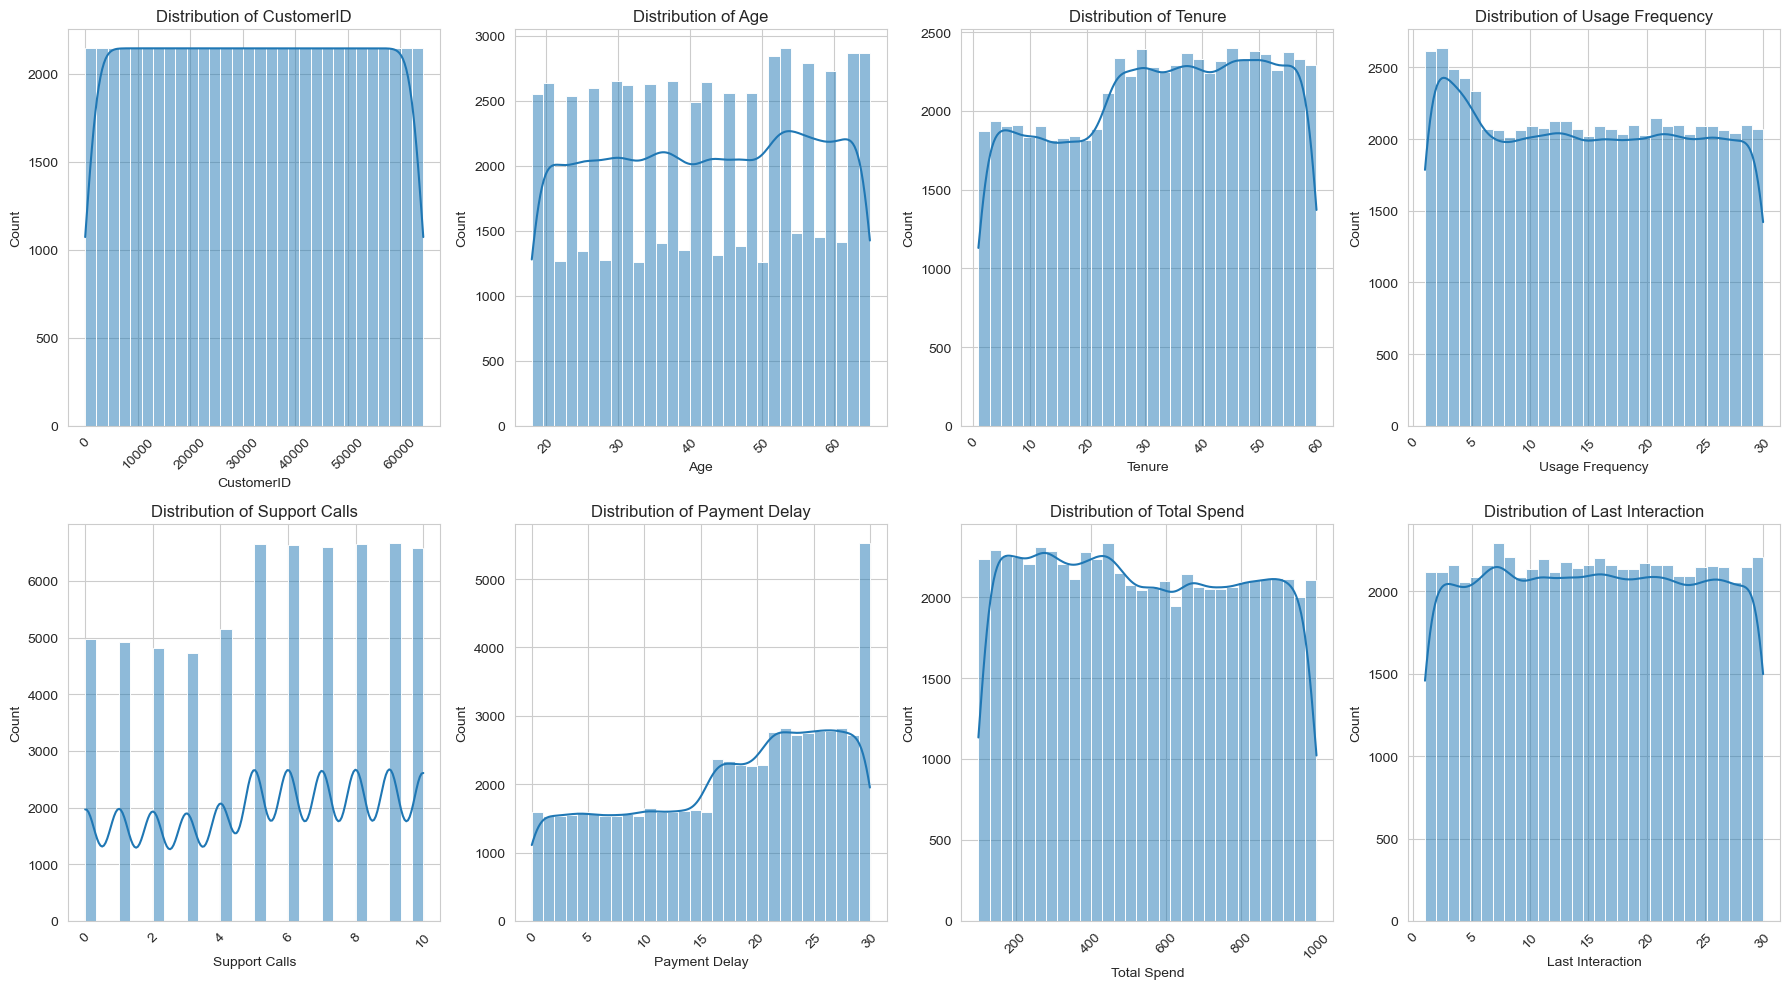

In [10]:
#Visualizing the Distributions
# Set style
sns.set_style("whitegrid")

# Create subplots for histograms
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(18, 10))

axes = axes.flatten()

for i, col in enumerate(num_cols):
    sns.histplot(churn_data[col], bins=30, kde=True, ax=axes[i])  # Histogram with density curve
    axes[i].set_title(f"Distribution of {col}")
    axes[i].tick_params(axis='x', rotation=45) 

plt.tight_layout()
plt.show()

From the graph;

1.Age does not seem perfectly normal.

2.Tenure
It has a multi-modal structure (several peaks).
Not a normal distribution.

3.Usage Frequency
Shows right skewness, meaning many users have lower usage frequencies.
Likely not normal.

4.Support Calls
Discrete values with visible oscillations, which suggests a non-normal distribution.
This is categorical-like data, so normality isn't expected.

5 Payment Delay
Has strong right skewness (big peak near the max value).
Not normal.

6.Total Spend
Shows right skewness with high density at lower values.
Not normal.

7.Last Interaction
Appears uniformly distributed, not normal.

### Hypothesis Testing to prove  normality
Ho: The data is normally distributed

H1: The data is not normally distributed

Null Hypothesis ( 𝐻 0): The data is normally distributed.

Alternative Hypothesis ( 𝐻 1): The data is not normally distributed.

If p-value > 0.05 → Fail to reject 𝐻 0

​→ Data is likely normal.

If p-value ≤ 0.05 → Reject 𝐻 0

→ Data is not normal.

In [11]:
#Using D'Agostino and Pearson’s Test to check for normality
for col in num_cols:
    stat, p = normaltest(churn_data[col])
    print(f"D'Agostino-Pearson Test for {col}: p-value={p:.4f}")
    if p > 0.05:
        print(f"✅ {col} appears normally distributed.\n")
    else:
        print(f"❌ {col} is NOT normally distributed.\n")

D'Agostino-Pearson Test for CustomerID: p-value=0.0000
❌ CustomerID is NOT normally distributed.

D'Agostino-Pearson Test for Age: p-value=0.0000
❌ Age is NOT normally distributed.

D'Agostino-Pearson Test for Tenure: p-value=0.0000
❌ Tenure is NOT normally distributed.

D'Agostino-Pearson Test for Usage Frequency: p-value=0.0000
❌ Usage Frequency is NOT normally distributed.

D'Agostino-Pearson Test for Support Calls: p-value=0.0000
❌ Support Calls is NOT normally distributed.

D'Agostino-Pearson Test for Payment Delay: p-value=0.0000
❌ Payment Delay is NOT normally distributed.

D'Agostino-Pearson Test for Total Spend: p-value=0.0000
❌ Total Spend is NOT normally distributed.

D'Agostino-Pearson Test for Last Interaction: p-value=0.0000
❌ Last Interaction is NOT normally distributed.



### The distribution of Age among customers?

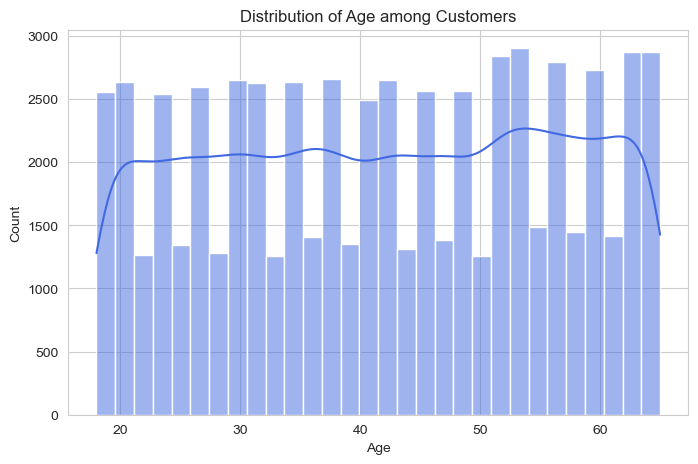

In [12]:
plt.figure(figsize=(8, 5))
sns.histplot(churn_data['Age'], bins=30, kde=True, color="royalblue")
plt.xlabel("Age")
plt.ylabel("Count")
plt.title("Distribution of Age among Customers")
plt.show()

The ages appear to be evenly spread across different ranges, meaning customers come from various age groups without significant dominance from any single range,suggesting a diverse customer base.

### Does Age affect churn?

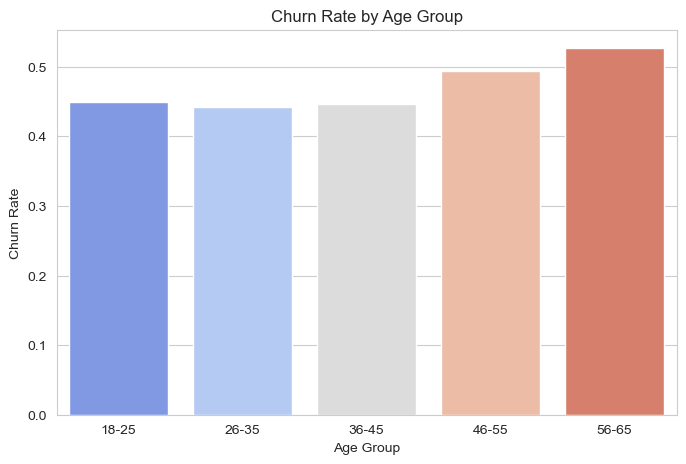

In [13]:
bins = [18, 25, 35, 45, 55, 65]
labels = ['18-25', '26-35', '36-45', '46-55', '56-65']

# Create age groups
churn_data['Age Group'] = pd.cut(churn_data['Age'], bins=bins, labels=labels)

# Calculate churn rate per age group
age_churn = churn_data.groupby('Age Group')['Churn'].mean()

# Plot churn rate by age group
plt.figure(figsize=(8, 5))
sns.barplot(x=age_churn.index, y=age_churn.values, palette='coolwarm')
plt.title("Churn Rate by Age Group")
plt.ylabel("Churn Rate")
plt.show()

From the Churn Rate by Age Group bar chart, we can observe that:

Older customers (46-65) have the highest churn rates, with the 56-65 age group having the highest overall churn rate.

Younger customers (18-25, 26-35) have lower churn rates compared to older customers but are still significantly high.

The churn rate gradually increases with age, indicating that older customers are more likely to churn compared to younger ones

### Do churn rates differ by Gender?

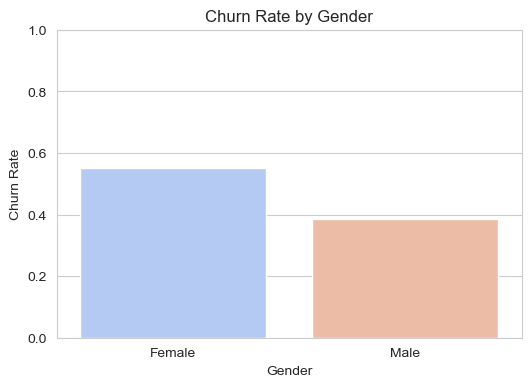

In [14]:
gender_churn = churn_data.groupby("Gender")["Churn"].mean()  # Calculate churn rate per gender

# Plot the results
plt.figure(figsize=(6, 4))
sns.barplot(x=gender_churn.index, y=gender_churn.values, palette="coolwarm")
plt.xlabel("Gender")
plt.ylabel("Churn Rate")
plt.title("Churn Rate by Gender")
plt.ylim(0, 1)  # Set y-axis limit for better visualization
plt.show()

From the bar chart, we observe that females have a higher churn rate compared to males. This suggests that gender might play a role in customer churn, with females being more likely to leave than males.

Different Customer Needs:

Female customers might have different expectations or requirements that are not being met.
Engagement Levels:

Males and females may interact differently with the product/service, influencing their likelihood to churn.

### Which features are most correlated with churn?

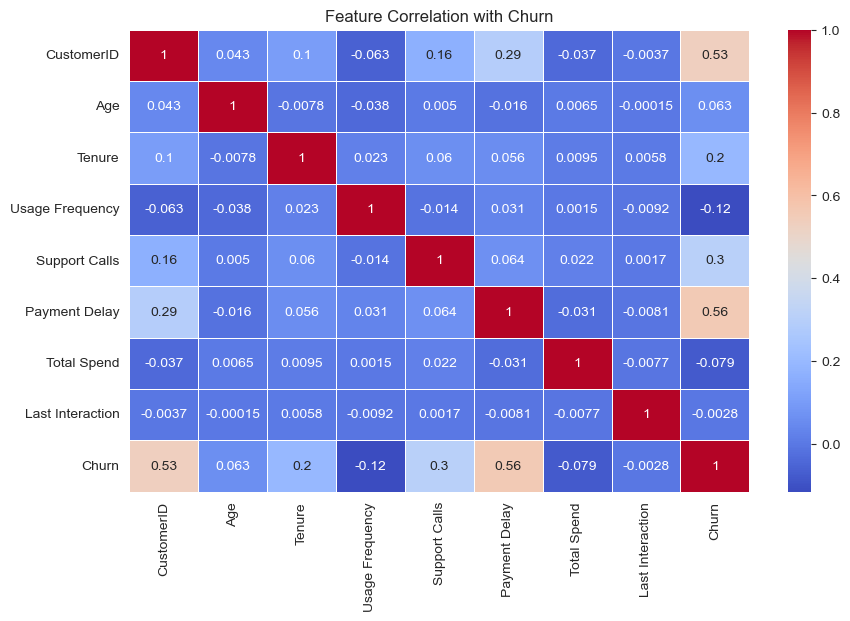

In [15]:
plt.figure(figsize=(10,6))
sns.heatmap(churn_data.select_dtypes(include=["number"]).corr(), annot=True, cmap="coolwarm", linewidths=0.5)
plt.title("Feature Correlation with Churn")
plt.show()

Based on the correlation heatmap, the most correlated features with churn are:

Payment Delay (0.56) – Customers with frequent or longer payment delays are more likely to churn.

CustomerID (0.53) – This shouldn't be used for prediction since it's just an identifier.

Support Calls (0.3) – More support calls may indicate dissatisfaction, increasing the likelihood of churn.

Tenure (0.2) – Longer tenure slightly correlates with churn, meaning newer customers might be more loyal.

Usage Frequency (-0.12) – Negative correlation suggests that lower usage frequency is linked to higher churn.

### Identifying Target Leakage
Target leakage occurs when a feature contains information that wouldn't be available at prediction time but is highly correlated with the target (Churn)

In [16]:
# Compare mean values for churned and non-churned customers
churn_data.groupby("Churn")[["Payment Delay", "Support Calls", "Tenure", "Usage Frequency"]].mean()

,Payment Delay,Support Calls,Tenure,Usage Frequency
Churn,,,,
0,12.453086,4.500753,28.826481,16.042915
1,22.334897,6.400617,35.515200,14.010593


In [17]:
# Define features (X) and target variable (y)
X = churn_data.drop(columns=['Churn', 'Age', 'CustomerID']) #because we created Age Group above and CustomerID is just an identifier
y = churn_data['Churn']

In [18]:
X

,Gender,Tenure,Usage Frequency,Support Calls,Payment Delay,Subscription Type,Contract Length,Total Spend,Last Interaction,Age Group
0,Female,25,14,4,27,Basic,Monthly,598,9,18-25
1,Female,28,28,7,13,Standard,Monthly,584,20,36-45
2,Male,27,10,2,29,Premium,Annual,757,21,46-55
3,Male,9,12,5,17,Premium,Quarterly,232,18,26-35
4,Female,58,24,9,2,Standard,Annual,533,18,46-55
...,...,...,...,...,...,...,...,...,...,...
64369,Female,33,12,6,21,Basic,Quarterly,947,14,36-45
64370,Male,6,1,5,22,Standard,Annual,923,9,36-45
64371,Male,39,14,8,30,Premium,Monthly,327,20,18-25
64372,Female,18,19,7,22,Standard,Monthly,540,13,46-55


In [19]:
y

0        1
1        0
2        0
3        0
4        0
        ..
64369    1
64370    1
64371    1
64372    1
64373    1
Name: Churn, Length: 64374, dtype: int64

In [20]:
#Split into train and test 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

### Preprocessing the data

In [21]:
# Identify all numerical and categorical columns
numerical_cols = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = X_train.select_dtypes(include=['object']).columns.tolist()

# Define preprocessing for numerical data (Imputation + Scaling)
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),  # Use median to handle outliers
    ('scaler', StandardScaler())  # Scale numerical features
])
# Define preprocessing for categorical data (Imputation + Encoding)
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  # Fill missing categorical values
    ('onehot', OneHotEncoder(handle_unknown='ignore'))  # Convert categorical values to numeric
])

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),  # Process all num cols
        ('cat', categorical_transformer, categorical_cols)  # Process all cat cols
    ]
)

### Apply Pipeline on Training & Test Data

In [22]:
# Fit and transform training data
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

# Convert to DataFrame
X_train_transformed = pd.DataFrame(X_train_transformed)
X_test_transformed = pd.DataFrame(X_test_transformed)

# Print shape to verify transformation
print(X_train_transformed.shape)
print(X_test_transformed.shape)

(57936, 14)
(6438, 14)


In [23]:
X_train_transformed.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,1.637930,1.013100,-0.127280,-1.597197,-0.018813,1.678593,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
1,-0.175481,-0.348306,1.156961,1.112142,0.245685,0.983380,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2,1.228450,-1.369360,0.193780,0.999253,0.989345,-0.175307,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
3,1.403942,-0.575207,-1.090461,0.547696,1.652507,0.404037,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
4,-0.116984,-0.688657,0.835900,0.321918,-0.179812,1.562724,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


In [24]:
imputer = SimpleImputer(strategy='mean')
X_train_transformed = pd.DataFrame(imputer.fit_transform(X_train_transformed), columns=X_train_transformed.columns)

In [25]:
X_train_transformed

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,1.637930,1.013100,-0.127280,-1.597197,-0.018813,1.678593,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
1,-0.175481,-0.348306,1.156961,1.112142,0.245685,0.983380,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2,1.228450,-1.369360,0.193780,0.999253,0.989345,-0.175307,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
3,1.403942,-0.575207,-1.090461,0.547696,1.652507,0.404037,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
4,-0.116984,-0.688657,0.835900,0.321918,-0.179812,1.562724,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57931,0.350993,-0.461756,-0.127280,1.225031,0.103852,-1.218126,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
57932,0.701976,1.693803,-0.769401,-1.597197,-0.359977,0.635774,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
57933,0.877467,-0.688657,-1.090461,0.999253,-0.333144,-1.102257,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
57934,1.462439,0.445848,1.478021,-0.919863,1.560508,1.330987,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0


In [26]:
X_train_transformed = X_train_transformed.dropna()

In [27]:
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)

# Fit model and get cluster labels
clusters = kmeans.fit_predict(X_train_transformed)

# Add cluster labels to the dataframe
X_train_transformed['Cluster'] = clusters

#### Visualizing with a Scatter Plot

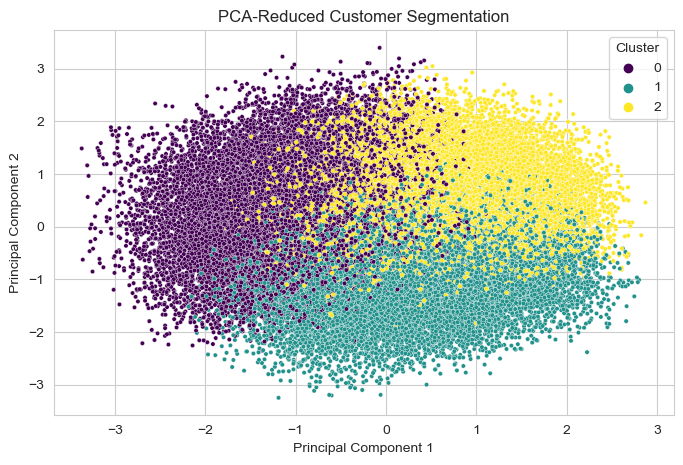

In [28]:
pca = PCA(n_components=2, whiten=False)  # Added whiten=Falseto avoid unnecessarily rescale since my X_transformed has already been scaled
X_pca = pca.fit_transform(X_train_transformed.drop(columns=['Cluster']))

# Convert to DataFrame
X_pca_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
X_pca_df['Cluster'] = clusters

# Plot PCA-transformed clusters
plt.figure(figsize=(8,5))
sns.scatterplot(data=X_pca_df, x='PC1', y='PC2', hue='Cluster', palette='viridis', s=10)
plt.title("PCA-Reduced Customer Segmentation")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()

Cluster 0 (Purple - Right Side)

These customers might have higher spending habits, stronger engagement, or premium product preferences.
They could represent loyal or high-value customers who frequently purchase or use your services because this cluster  dominates the positive side of PC1 and is spread across different values of PC2

Cluster 1 (Teal - Center & Lower Right)
These customers could be moderate spenders or average engagement customers who interact with your business but not as much as Cluster 0.
They might be occasional buyers or budget-conscious customers because this cluster is located mainly around the middle but slightly shifting towards negative PC1

Cluster 2 (Yellow - Left Side)
These customers might have lower engagement, lower spending, or less frequent interactions with your business.
They could be new customers, one-time buyers, or those at risk of churning because this cluster is on the negative side of PC1.

In [29]:
X_train_transformed = X_train_transformed.drop(columns=['Cluster'], errors='ignore')

### Logistic Regression Model(Baseline)

In [30]:
X_train_transformed.columns = X_train_transformed.columns.astype(str)

model = LogisticRegression()

# Train model
model.fit(X_train_transformed, y_train)

LogisticRegression()

In [31]:
print(set(X_train_transformed.columns) - set(X_test_transformed.columns))  # Missing columns
print(set(X_test_transformed.columns) - set(X_train_transformed.columns))  # Extra columns

{'8', '9', '12', '3', '10', '4', '5', '1', '0', '2', '13', '11', '7', '6'}
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13}


In [32]:
X_test_transformed.columns = X_test_transformed.columns.astype(str)  # Convert to string

In [33]:
X_test_transformed = X_test_transformed[X_train_transformed.columns]

In [34]:
# Predict on test set
y_pred = model.predict(X_test_transformed)  # Ensure X_test_transformed is also preprocessed

# Get probability scores
y_prob = model.predict_proba(X_test_transformed)[:, 1]  # Probability of churn (class 1)

In [35]:
# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# Classification Report (Precision, Recall, F1-score)
print("Classification Report:\n", classification_report(y_test, y_pred))

# ROC-AUC Score
roc_auc = roc_auc_score(y_test, y_prob)
print(f"ROC-AUC Score: {roc_auc:.4f}")

Accuracy: 0.8361
Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.83      0.85      3466
           1       0.81      0.84      0.83      2972

    accuracy                           0.84      6438
   macro avg       0.84      0.84      0.84      6438
weighted avg       0.84      0.84      0.84      6438

ROC-AUC Score: 0.9079


In [36]:
# Initialize Decision Tree with pruning
dt_model = DecisionTreeClassifier(
    max_depth=5,  # Limits the depth of the tree
    min_samples_split=10,  # Minimum samples required to split a node
    min_samples_leaf=5,  # Minimum samples required in a leaf node
    random_state=42
)

# Train the pruned Decision Tree
dt_model.fit(X_train_transformed, y_train)

# Predictions
dt_preds = dt_model.predict(X_test_transformed)
dt_probs = dt_model.predict_proba(X_test_transformed)[:, 1]

# Evaluate Model
print("Pruned Decision Tree Results:")
print("Accuracy:", accuracy_score(y_test, dt_preds))
print("ROC-AUC Score:", roc_auc_score(y_test, dt_probs))
print("Classification Report:\n", classification_report(y_test, dt_preds))

Pruned Decision Tree Results:
Accuracy: 0.9352283317800559
ROC-AUC Score: 0.9893442373093283
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.90      0.94      3466
           1       0.89      0.98      0.93      2972

    accuracy                           0.94      6438
   macro avg       0.94      0.94      0.94      6438
weighted avg       0.94      0.94      0.94      6438



In [37]:
# Initialize and train the Decision Tree model
#dt_model = DecisionTreeClassifier(random_state=42)
#dt_model.fit(X_train_transformed, y_train)

In [38]:
# Make predictions
#dt_preds = dt_model.predict(X_test_transformed)
#dt_probs = dt_model.predict_proba(X_test_transformed)[:, 1]

# Evaluate Decision Tree
#print("Decision Tree Results:")
#print("Accuracy:", accuracy_score(y_test, dt_preds))
#print("ROC-AUC Score:", roc_auc_score(y_test, dt_probs))
#print("Classification Report:\n", classification_report(y_test, dt_preds))

In [51]:
pruned_tree_model = DecisionTreeClassifier(ccp_alpha=0.01)  # Use your pruning value
pruned_tree_model.fit(X_train_transformed, y_train)  # Retrain if needed

import pickle

# Assuming `model` is your trained DecisionTreeClassifier or DecisionTreeRegressor
with open("pruned_decision_tree.pkl", "wb") as file:
    pickle.dump(pruned_tree_model, file)
print("Model saved successfully!")

Model saved successfully!


In [40]:
#Predict on the test set
predictions = pruned_tree_model.predict(X_test_transformed)

# Predict probabilities (if needed for ROC-AUC)
probabilities = pruned_tree_model.predict_proba(X_test_transformed)[:, 1]

# Print sample predictions
print("Sample Predictions:", predictions[:10])

Sample Predictions: [0 0 1 0 0 0 0 0 1 0]


In [41]:
#reload your pruned model and evaluate its performance
# Accuracy
accuracy = accuracy_score(y_test, predictions)
print("Accuracy:", accuracy)

# ROC-AUC Score
roc_auc = roc_auc_score(y_test, probabilities)
print("ROC-AUC Score:", roc_auc)

# Classification Report
print("Classification Report:\n", classification_report(y_test, predictions))

Accuracy: 0.9285492388940665
ROC-AUC Score: 0.9843286329263548
Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.96      0.94      3466
           1       0.95      0.89      0.92      2972

    accuracy                           0.93      6438
   macro avg       0.93      0.93      0.93      6438
weighted avg       0.93      0.93      0.93      6438



In [42]:
import joblib

# Load the trained model
model = joblib.load("pruned_decision_tree.pkl")

# Display feature names
model.feature_names_in_

array(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
       '13'], dtype=object)

In [43]:
import streamlit as st 

In [44]:
st.__version__

'1.43.2'

In [45]:
import joblib

In [46]:
joblib.__version__

'1.2.0'

In [47]:
import distutils

In [48]:
distutils.__version__

'3.11.5'

In [50]:
import pickle as pkl